# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

In this project I combined transaction, demographic and offer data to determine which demographic groups respond best to which offer type.


## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Business Understanding

## Question to answer: 
    Which demographic groups response best to which offer type?

# Data Understanding

## Gather

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
profile.sample(5)

,gender,age,id,became_member_on,income
2834,M,54,e0b28061c5aa43b8a78b97e63485a736,20170211,89000.0
5488,F,44,de0945c55cec445aa4d4132d3c6118d3,20160310,100000.0
7037,M,72,d10c2674404040778c0bf927ef316082,20170217,32000.0
16849,M,24,3408fd05c781401f8442fb6dbaaea9c7,20170201,48000.0
10775,F,68,9f83b1bf4fba46f48d0b1e1c63765f94,20170615,74000.0


In [4]:
transcript.query("person == 'd56835f0fc28499fa58eba822b291660'")

,person,event,value,time
58879,d56835f0fc28499fa58eba822b291660,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168
67451,d56835f0fc28499fa58eba822b291660,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168
78219,d56835f0fc28499fa58eba822b291660,transaction,{'amount': 11.05},192
78220,d56835f0fc28499fa58eba822b291660,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,192
82292,d56835f0fc28499fa58eba822b291660,transaction,{'amount': 15.01},204
116534,d56835f0fc28499fa58eba822b291660,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336
140444,d56835f0fc28499fa58eba822b291660,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},372
142467,d56835f0fc28499fa58eba822b291660,transaction,{'amount': 22.7},378
142468,d56835f0fc28499fa58eba822b291660,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,378
156332,d56835f0fc28499fa58eba822b291660,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},408


- what's the time unit?


In [5]:
# check if the informetional offer has a complete record 
transcript[transcript["event"].str.endswith("completed") & transcript["value"].str.endswith("bed'}")]

,person,event,value,time


In [6]:
transcript[transcript["event"].str.endswith("completed") & transcript["value"].str.endswith("837'}")]

,person,event,value,time


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [9]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [10]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

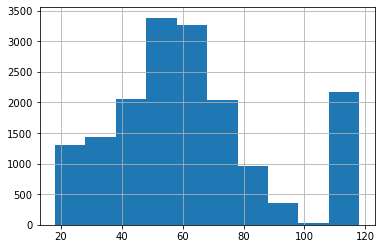

In [11]:
profile.age.hist()

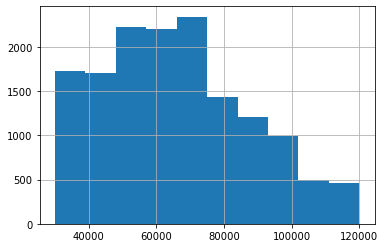

In [12]:
profile.income.hist()

In [13]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [14]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [15]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Assess
### portfolio:
- duration unit (days) inconsitent with time unit in `transcript` data

### profile:
- Age & income are continues data
- Gender & income have null values

### transcript:
- value column has data in dict form
- in value column, some dict have `offer_id` & others have `offer id`

# Prepare Data
## Clean

In [16]:
portfolio_copy = portfolio.copy()
profile_copy = profile.copy()
transcript_copy = transcript.copy()

- convert duration from days to hours

In [17]:
# convert 'duration' from days to hours
portfolio_copy["duration"] = portfolio["duration"] * 24
portfolio_copy

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5


- categorize the income column

In [18]:
std = profile.income.std()
mean = profile.income.mean()

def assign_income_level(income):
    '''
    label the income as unknown, high, moderate or low depending on the stander deviation
    arguments:
    income (float): the person income
    
    returns: unknown, high, moderate or low
    '''
    low_threashold = mean - std
    high_threashold = mean + std
    if np.isnan(income):
        return "unknown"
    elif income > high_threashold:
        return "high"
    elif income > low_threashold:
        return "moderate"
    else:
        return "low"
    

profile_copy["income_level"] = profile.income.apply(assign_income_level)
profile_copy

,gender,age,id,became_member_on,income,income_level
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,unknown
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,high
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,unknown
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,high
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,unknown
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,moderate
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,moderate
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,moderate
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,moderate


- convert age to groups

In [19]:
def assign_age_group(age):
    '''
    label the age as old, mid-age or youth
    arguments:
    income (float): the person income
    
    returns: unknown, high, moderate or low
    '''
    if age > 65:
        return "old"
    elif age > 40:
        return "mid-age"
    else:
        return "youth"
    
profile_copy["age_group"] = profile.age.apply(assign_age_group)
profile_copy

,gender,age,id,became_member_on,income,income_level,age_group
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,unknown,old
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,high,mid-age
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,unknown,old
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,high,old
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,unknown,old
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,moderate,mid-age
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,moderate,mid-age
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,moderate,mid-age
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,moderate,old


In [20]:
# separate the offer id & amount, each to a new column

def get_offer_id(value_dict):
    '''
    get the offer id from the dectionary
    arguments:
    value_dict (dict): dictionary contain the offer id or the trans. amount
    
    returns: offer id or np.nan
    '''
    if "offer id" in value_dict:
        return value_dict["offer id"]
    elif "offer_id" in value_dict:
        return value_dict["offer_id"]
    else:
        return np.nan

transcript_copy["offer_id"] = transcript["value"].apply(get_offer_id)
transcript_copy["amount"] = transcript["value"].apply(lambda v: v["amount"] if "amount" in v else np.nan)
transcript_copy.drop(columns="value", inplace=True)
transcript_copy

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53


In [21]:
def get_offer_duration(offer_id):
    '''
    use offer id to get its duration from `portfolio_copy` dataframe
    arguments:
    offer_id (str): the ID of the offer
    
    returns: offer duration in hours
    '''
    mask = portfolio_copy["id"] == offer_id
    return portfolio_copy.loc[mask, "duration"].values[0]

get_offer_duration("0b1e1539f2cc45b7b9fa7c272da2e1d7")

240

In [ ]:
def has_view_record(df, row):
    '''
    search dataframe to get a view record for a recieved offer
    
    arguments:
    df (pd.DataFrame): DataFrame contain the transaction of a person
    row (pd.Series): Series represent the offer receiving record
    
    returns: (bool) True if the record is found, False otherwise
    '''
    condition = "event == 'offer viewed' & time <= {} & offer_id == '{}'".format(row["time"] + get_offer_duration(row["offer_id"])
                                                                                  , row["offer_id"])
    person = row["person"]
    view_row = df.loc[row.name:, :].query(condition)
    return not view_row.empty

def has_complete_record(row):
    '''
    search `transcript_copy` dataframe to get a complete record for a recieved offer
    
    arguments:
    row (pd.Series): Series represent the offer receiving record
    
    returns: (bool) True if a complete record is found, False otherwise
    '''
    person = row["person"]
    person_transcript = transcript_copy.query(f"person == '{person}'")
    if not has_view_record(person_transcript, row): return False
    
    condition = "event == 'offer completed' & time <= {} & offer_id == '{}'".format(row["time"] + get_offer_duration(row["offer_id"])
                                                                                  , row["offer_id"])
    
    complete_row = person_transcript.loc[row.name:, :].query(condition)
    return not complete_row.empty

transcript_copy["completed"] = False
transcript_copy["completed"] = transcript_copy.query("event == 'offer received'").apply(has_complete_record, axis=1)
transcript_copy


In [ ]:
# create an array contain the offer IDs of the informational offers
info_offer_ids = portfolio_copy.query("offer_type == 'informational'")["id"].values

info_offer_ids


In [ ]:
def completed_with_transaction(row):
    '''
    search `transcript_copy` dataframe to get a transaction that is infelunced by an informational offer
    
    arguments:
    row (pd.Series): Series represent an informational offer receiving record
    
    returns: (bool) True if a complete record is found, False otherwise
    '''
    person = row["person"]
    person_transcript = transcript_copy.query(f"person == '{person}'")
    if not has_view_record(person_transcript, row): return False
    
    condition = "event == 'transaction' & time <= {}".format(row["time"] + get_offer_duration(row["offer_id"]))
    person = row["person"]
    complete_row = transcript_copy.query(f"person == '{person}'").loc[row.name:, :].query(condition)
    return not complete_row.empty

is_info_offer = transcript_copy["offer_id"].isin(info_offer_ids)
is_trans = transcript_copy["event"] == "transaction"
transcript_copy.loc[is_info_offer, "completed"] = transcript_copy[is_info_offer].query("event == 'offer received'").apply(completed_with_transaction, axis=1)
transcript_copy



In [ ]:
transcript_copy.query("person == 'b3a1272bc9904337b331bf348c3e8c17'")

In [ ]:
# filter the DataFrame to get the completed transactions only
df_clean = transcript_copy.query("event == 'offer received' & completed == True")
df_clean

In [ ]:
# group offers by person and offer type, then count the offers
person_offer = df_clean.merge(portfolio_copy[["id", "offer_type"]], left_on="offer_id", right_on="id")
person_offer = person_offer.groupby(["person", "offer_type"])[["completed"]].count()
person_offer = person_offer.unstack()
person_offer.reset_index(inplace=True)
person_offer.columns = ["person", "bogo", "discount", "informational"]

person_offer

In [ ]:
# merge the offers and persons data
person_offer = person_offer.merge(profile_copy, left_on="person", right_on="id")
person_offer

## Data Visualization

In [ ]:
# group by age group and get the total completed offers
age_offer_response = person_offer.groupby("age_group")[["bogo", "discount", "informational"]].sum()
age_offer_response

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name="bogo", x=age_offer_response.index, y=age_offer_response["bogo"]),
    go.Bar(name="discount", x=age_offer_response.index, y=age_offer_response["discount"]),
    go.Bar(name="informational", x=age_offer_response.index, y=age_offer_response["informational"]),
])

fig.update_layout(title="Offer Infeluence per Age Group")
fig.show()

In [ ]:
# group by income level and get the total completed offers

income_offer_response = person_offer.groupby("income_level")[["bogo", "discount", "informational"]].sum()
income_offer_response

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name="bogo", x=income_offer_response.index, y=income_offer_response["bogo"]),
    go.Bar(name="discount", x=income_offer_response.index, y=income_offer_response["discount"]),
    go.Bar(name="informational", x=income_offer_response.index, y=income_offer_response["informational"]),
])

fig.update_layout(title="Offer Infeluence per Income Level")
fig.show()

## Data Modeling

In [ ]:

# get the interested columns from DataFrames `transcript_copy`, `profile_copy` and `portfolio_copy`
df_model = transcript_copy.query("event == 'offer received'").merge(profile_copy, left_on="person", right_on="id")
df_model = df_model.merge(portfolio_copy, left_on="offer_id", right_on="id")

to_drop_columns = ["person", "event", "time", "offer_id", "amount", "id_x", "became_member_on"
                  , "income_level", "age_group", "channels", "id_y"]
df_model.drop(columns=to_drop_columns, inplace=True)

df_model

In [ ]:
# impute the missing `income` with 0
mask = df_model["income"].isna()
df_model.loc[mask, "income"] = 0

# impute the missing `gender` with 'O' (Other)
mask = df_model["gender"].isna()
df_model.loc[mask, "gender"] = "O"

df_model

In [ ]:
from sklearn.preprocessing import normalize

# rescale all the numeric values
columns = ["age", "income", "reward", "difficulty", "duration"]
df_model[columns] = normalize(df_model[columns])

df_model

In [ ]:
# create dummy columns for the categorical data
df_model = pd.get_dummies(df_model, columns=["gender", "offer_type"])
df_model

In [ ]:
from sklearn.preprocessing import LabelEncoder

# convert completed column to numeric values 0: False, 1: True
df_model["completed"] = LabelEncoder().fit_transform(df_model["completed"])

df_model

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.iloc[:, 1:]
y = df_model.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



## Evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

In [ ]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)

print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))